In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, altfile='yy_quadh_bkg10_soft025_md_{base}', report=False) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile='yy_quadh_bkg10_soft025_md_{base}'), Tree(module.Run2_UL18.TTJets, altfile='yy_quadh_bkg10_soft025_md_{base}')])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


In [6]:
event_filter = FilterSequence(
    eightb.selected_jet_pt(),
    eightb.selected_jet_btagwp()
)

signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


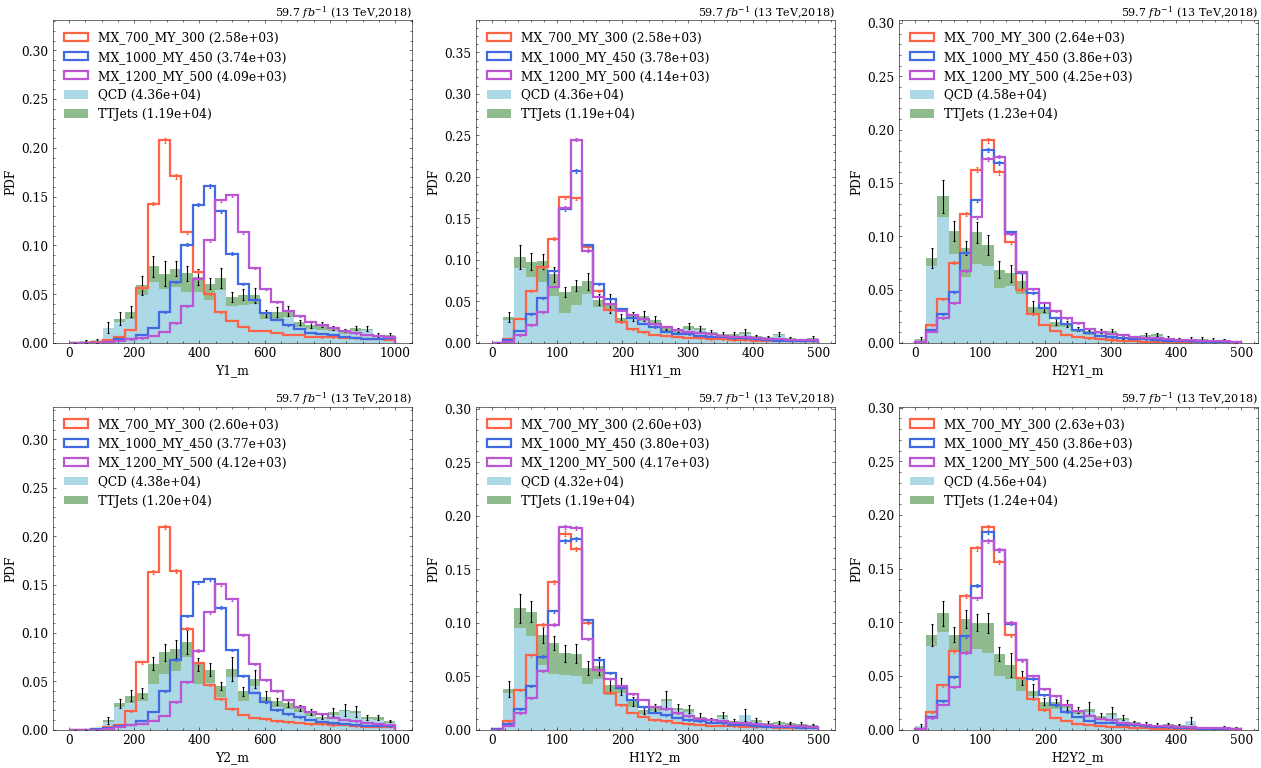

In [7]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=['Y1_m','H1Y1_m','H2Y1_m','Y2_m','H1Y2_m','H2Y2_m'],
    binlist=[(0,1000,30),(0,500,30),(0,500,30)]*2
)

100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


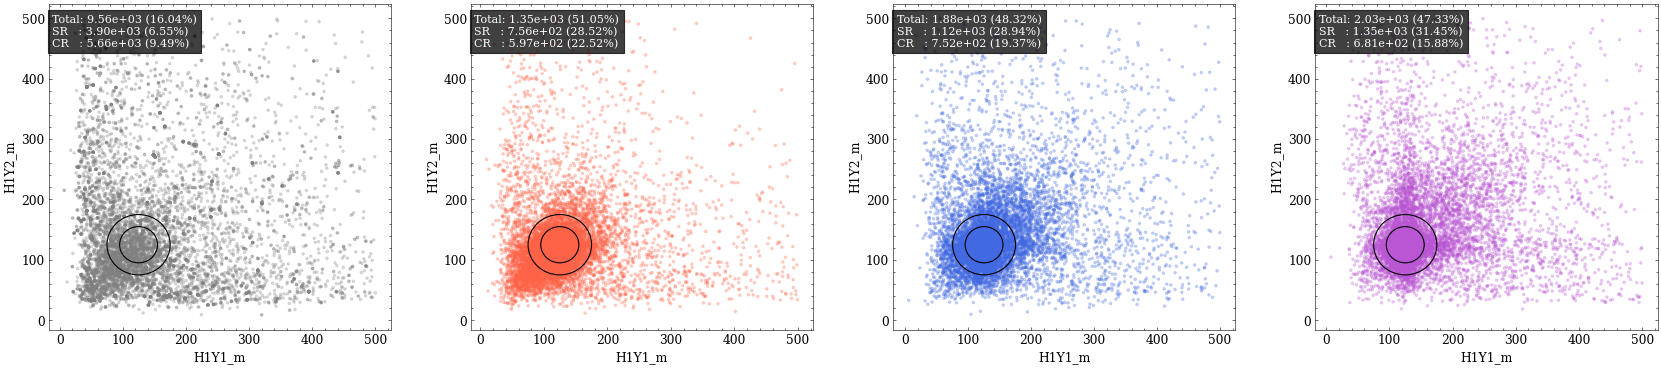

In [8]:
study.quick2d(
    signal+bkg,
    varlist=['H1Y1_m','H1Y2_m'],
    binlist=[(0,500,30)]*2,
    scatter=True,
    exe=[
        draw_concentric(x=125,y=125,r1=30,r2=50),
    ]
)

In [9]:
h4m = signal.higgs_m.apply(lambda m : m[:10000]).cat.to_numpy()

In [12]:
from scipy import optimize

def calc_dm(center):
    n = len(center)
    dm = np.sqrt( np.sum( (h4m[:,:n]-center)**2, axis=-1 ) )
    return dm

def _find_best_(center):
    dm = calc_dm(center)
    mask = dm < 30*np.sqrt(len(center))
    return 1-np.mean(mask)
    # mu = ak.mean(dm[dm < 100])
    # return mu

r0 = (125,125,125,125)
center = optimize.fmin(_find_best_, r0,)
center

Optimization terminated successfully.
         Current function value: 0.614667
         Iterations: 63
         Function evaluations: 165


array([121.17847558, 116.52753341, 115.39821773, 110.51669426])

In [13]:
def get_higgs_dm(t, center=center):
    dm = [
        np.abs(t.higgs_m[:,i]-m)
        for i, m in enumerate(center)
    ]  
    dm = ak_stack(dm, axis=1)
    t.extend(higgs_dm=dm)
(signal+bkg+data).apply(get_higgs_dm)

[None, None, None, None, None]

100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


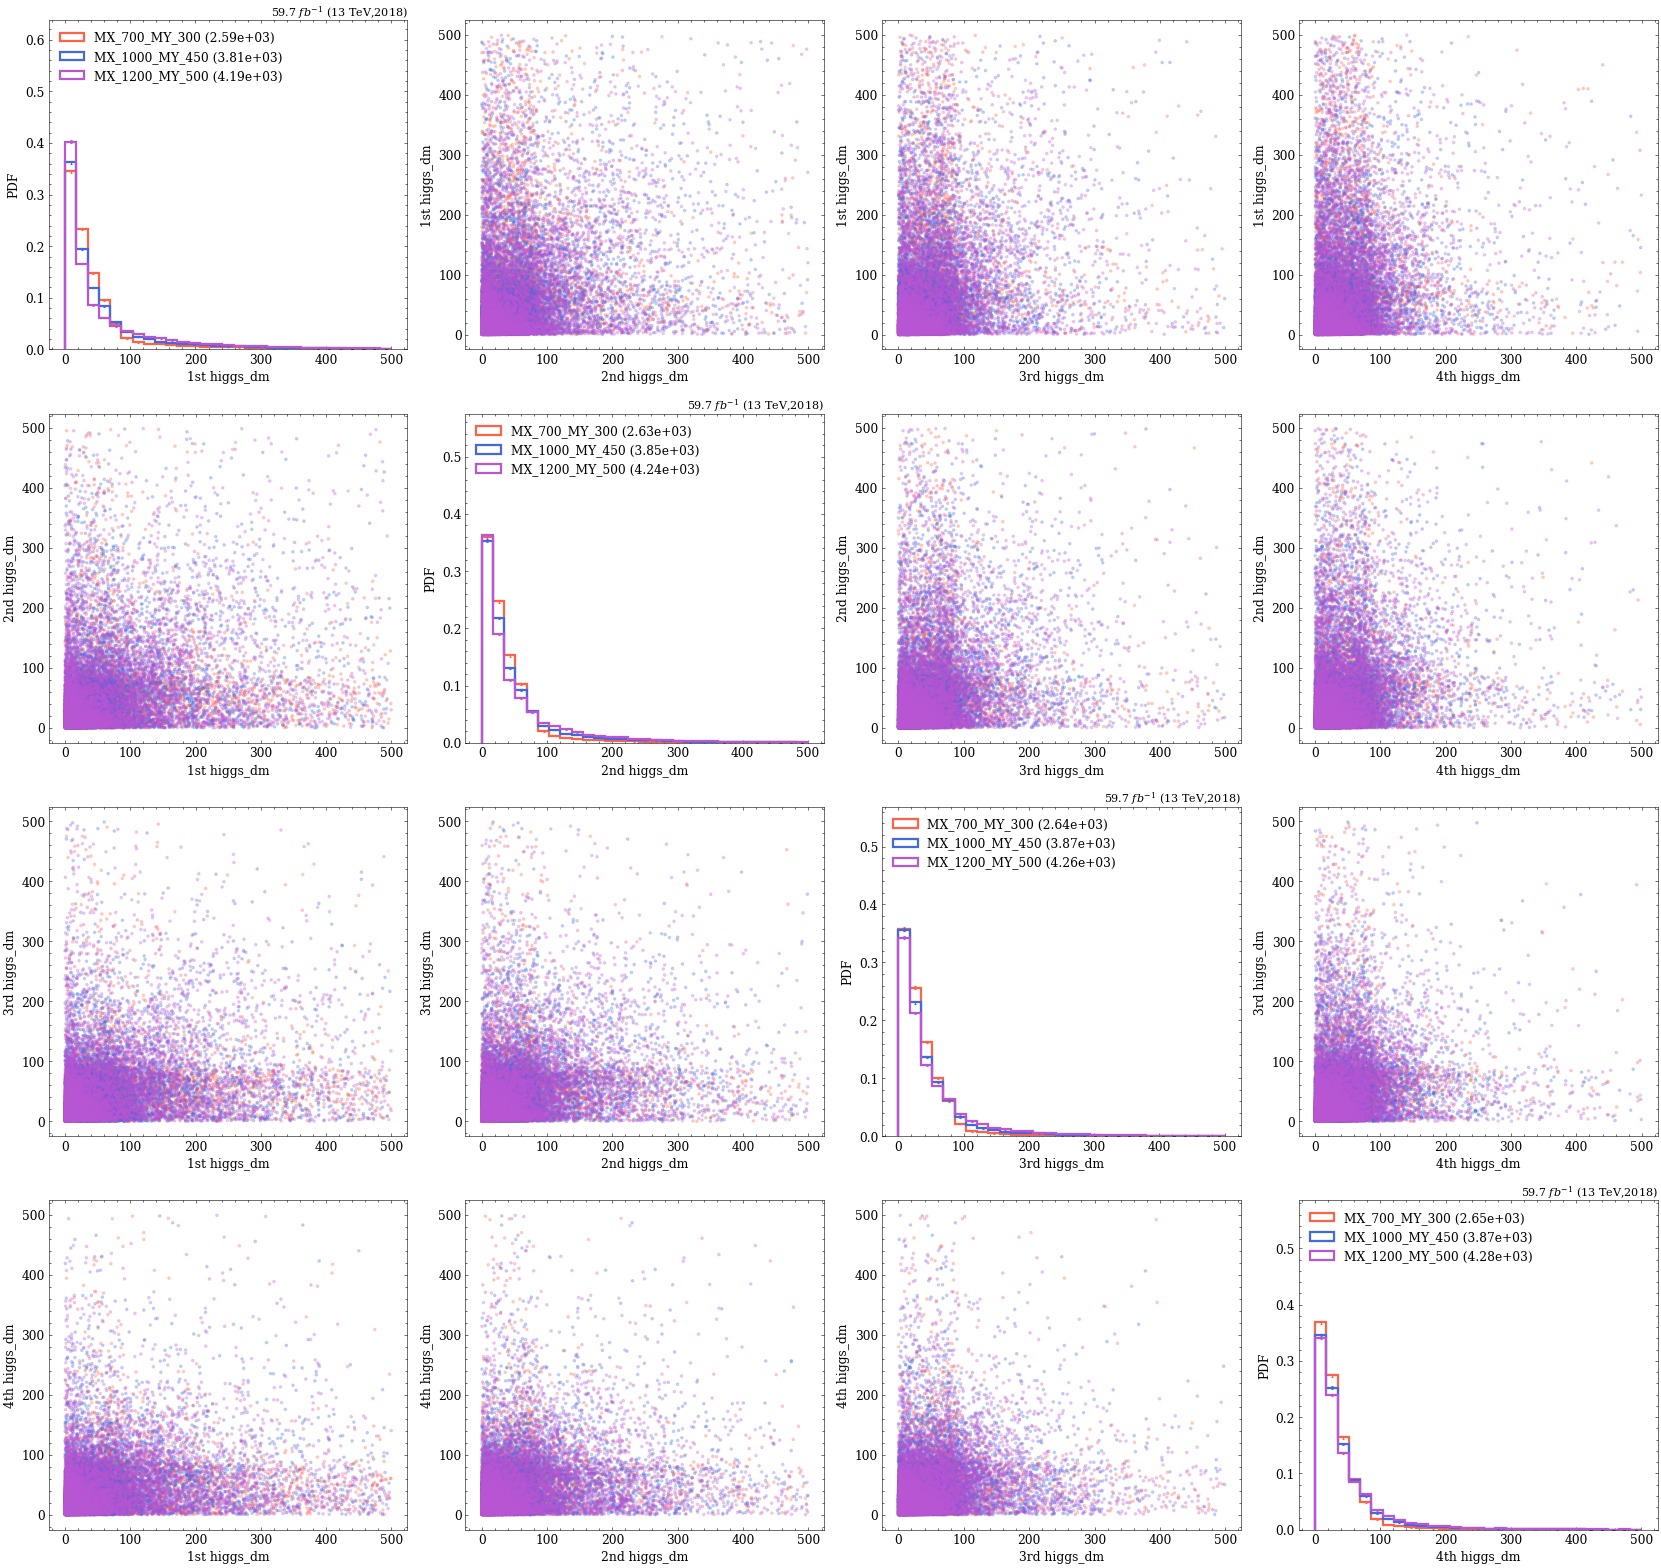

In [25]:
study.pairplot(
    signal, 
    legend=True,
    efficiency=True,
    varlist=[f'higgs_dm[:,{i}]' for i in range(4)],
    binlist=[(0, 500, 30)]*4,
    # scatter=dict(fraction=500, alpha=0.15, size=50)
)

100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


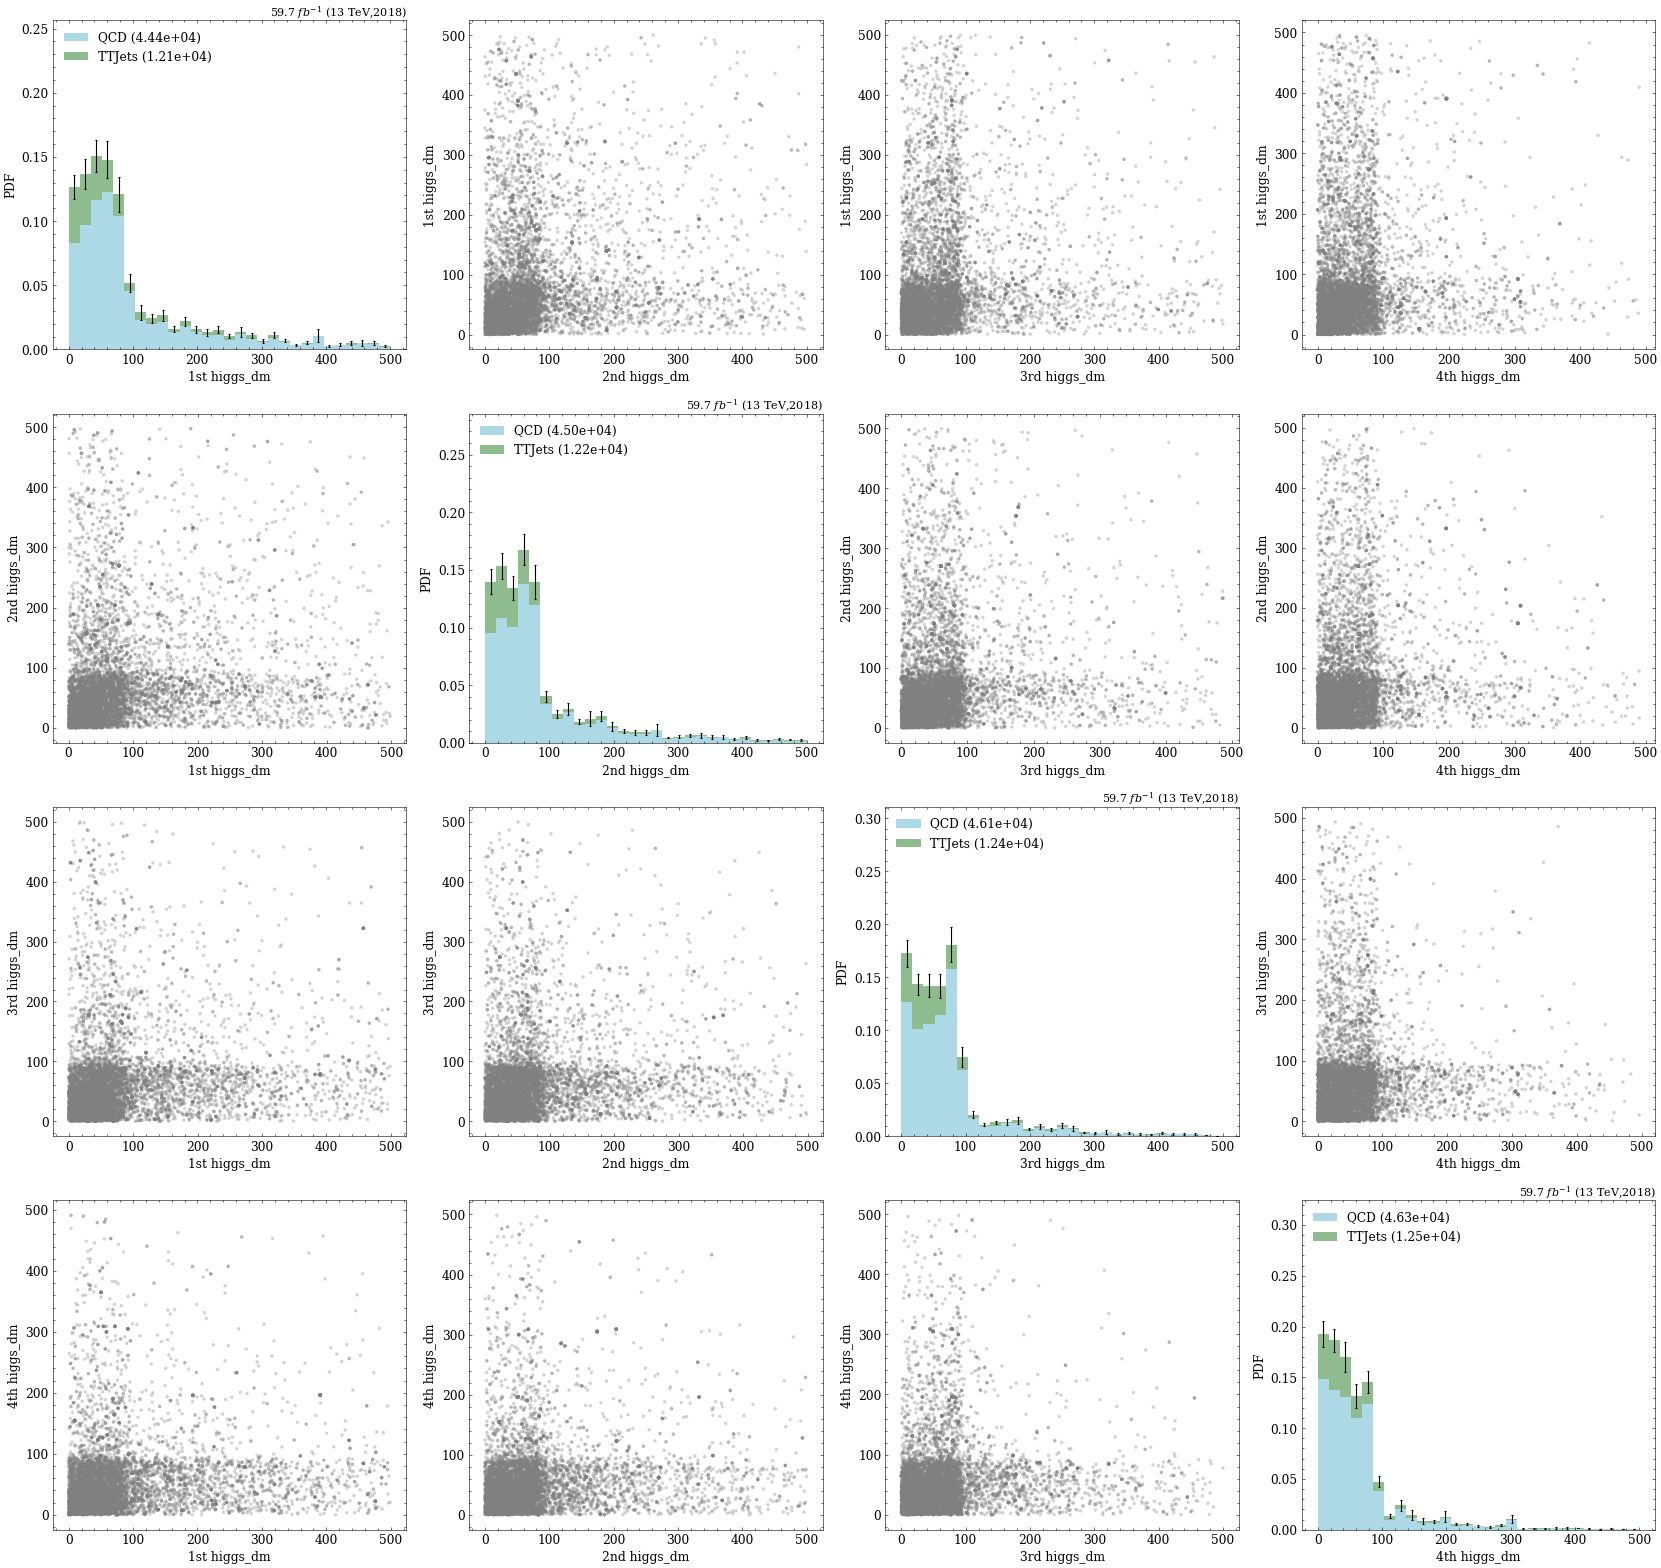

In [26]:
study.pairplot(
    # signal+bkg,
    bkg,
    legend=True,
    efficiency=True,
    varlist=[f'higgs_dm[:,{i}]' for i in range(4)],
    binlist=[(0, 500, 30)]*4,
    # scatter=dict(fraction=500, alpha=0.15, size=50)
)

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


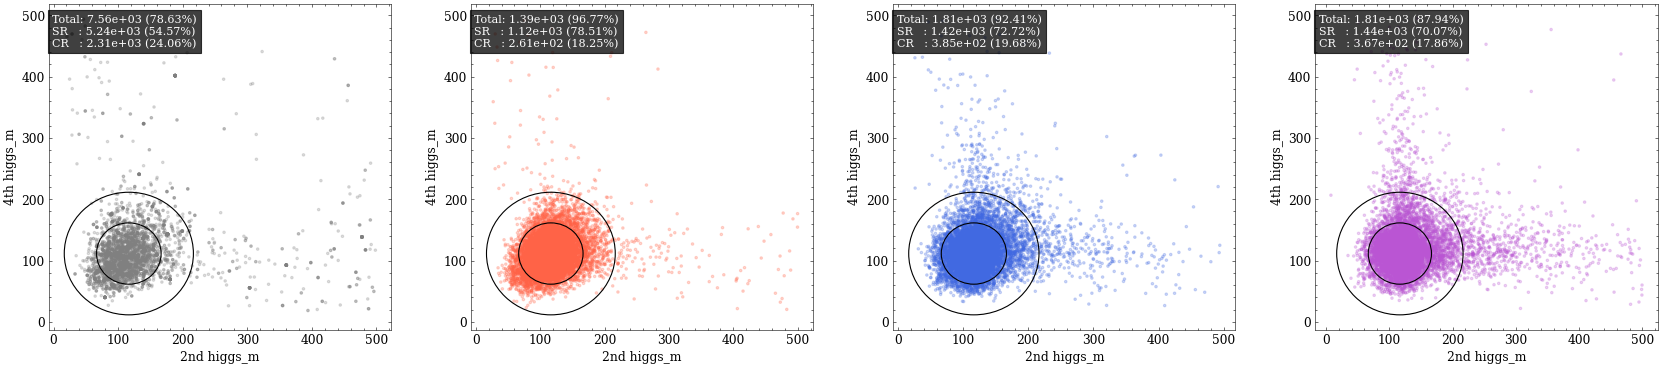

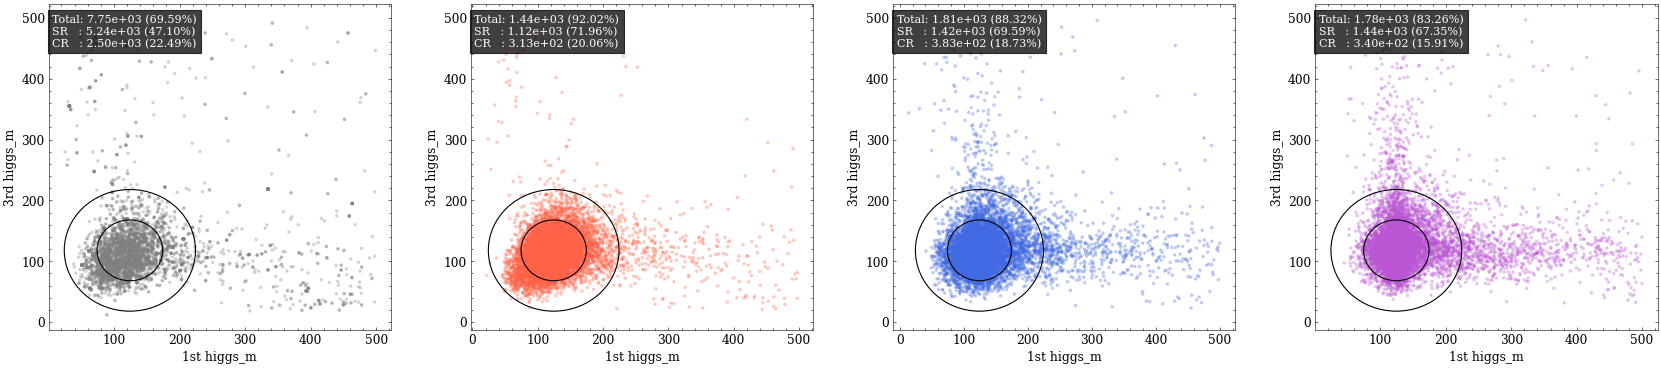

In [18]:
h02_dm = higgs_dm(h=[0,2])

study.quick2d(
    signal+bkg,
    masks=lambda t : h02_dm(t) < 50,
    varlist=[f'higgs_m[:,{i}]' for i in (1,3)],
    binlist=[(0, 500, 30)]*2,
    scatter=True,
    exe=draw_concentric(x=center[1],y=center[3],r1=50, r2=100)
)

h13_dm = higgs_dm(h=[1,3])

study.quick2d(
    signal+bkg,
    masks=lambda t : h13_dm(t) < 50,
    varlist=[f'higgs_m[:,{i}]' for i in (0,2)],
    binlist=[(0, 500, 30)]*2,
    scatter=True,
    exe=draw_concentric(x=center[0],y=center[2],r1=50, r2=100)
)

In [19]:
center[3]

111.35773735025099

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


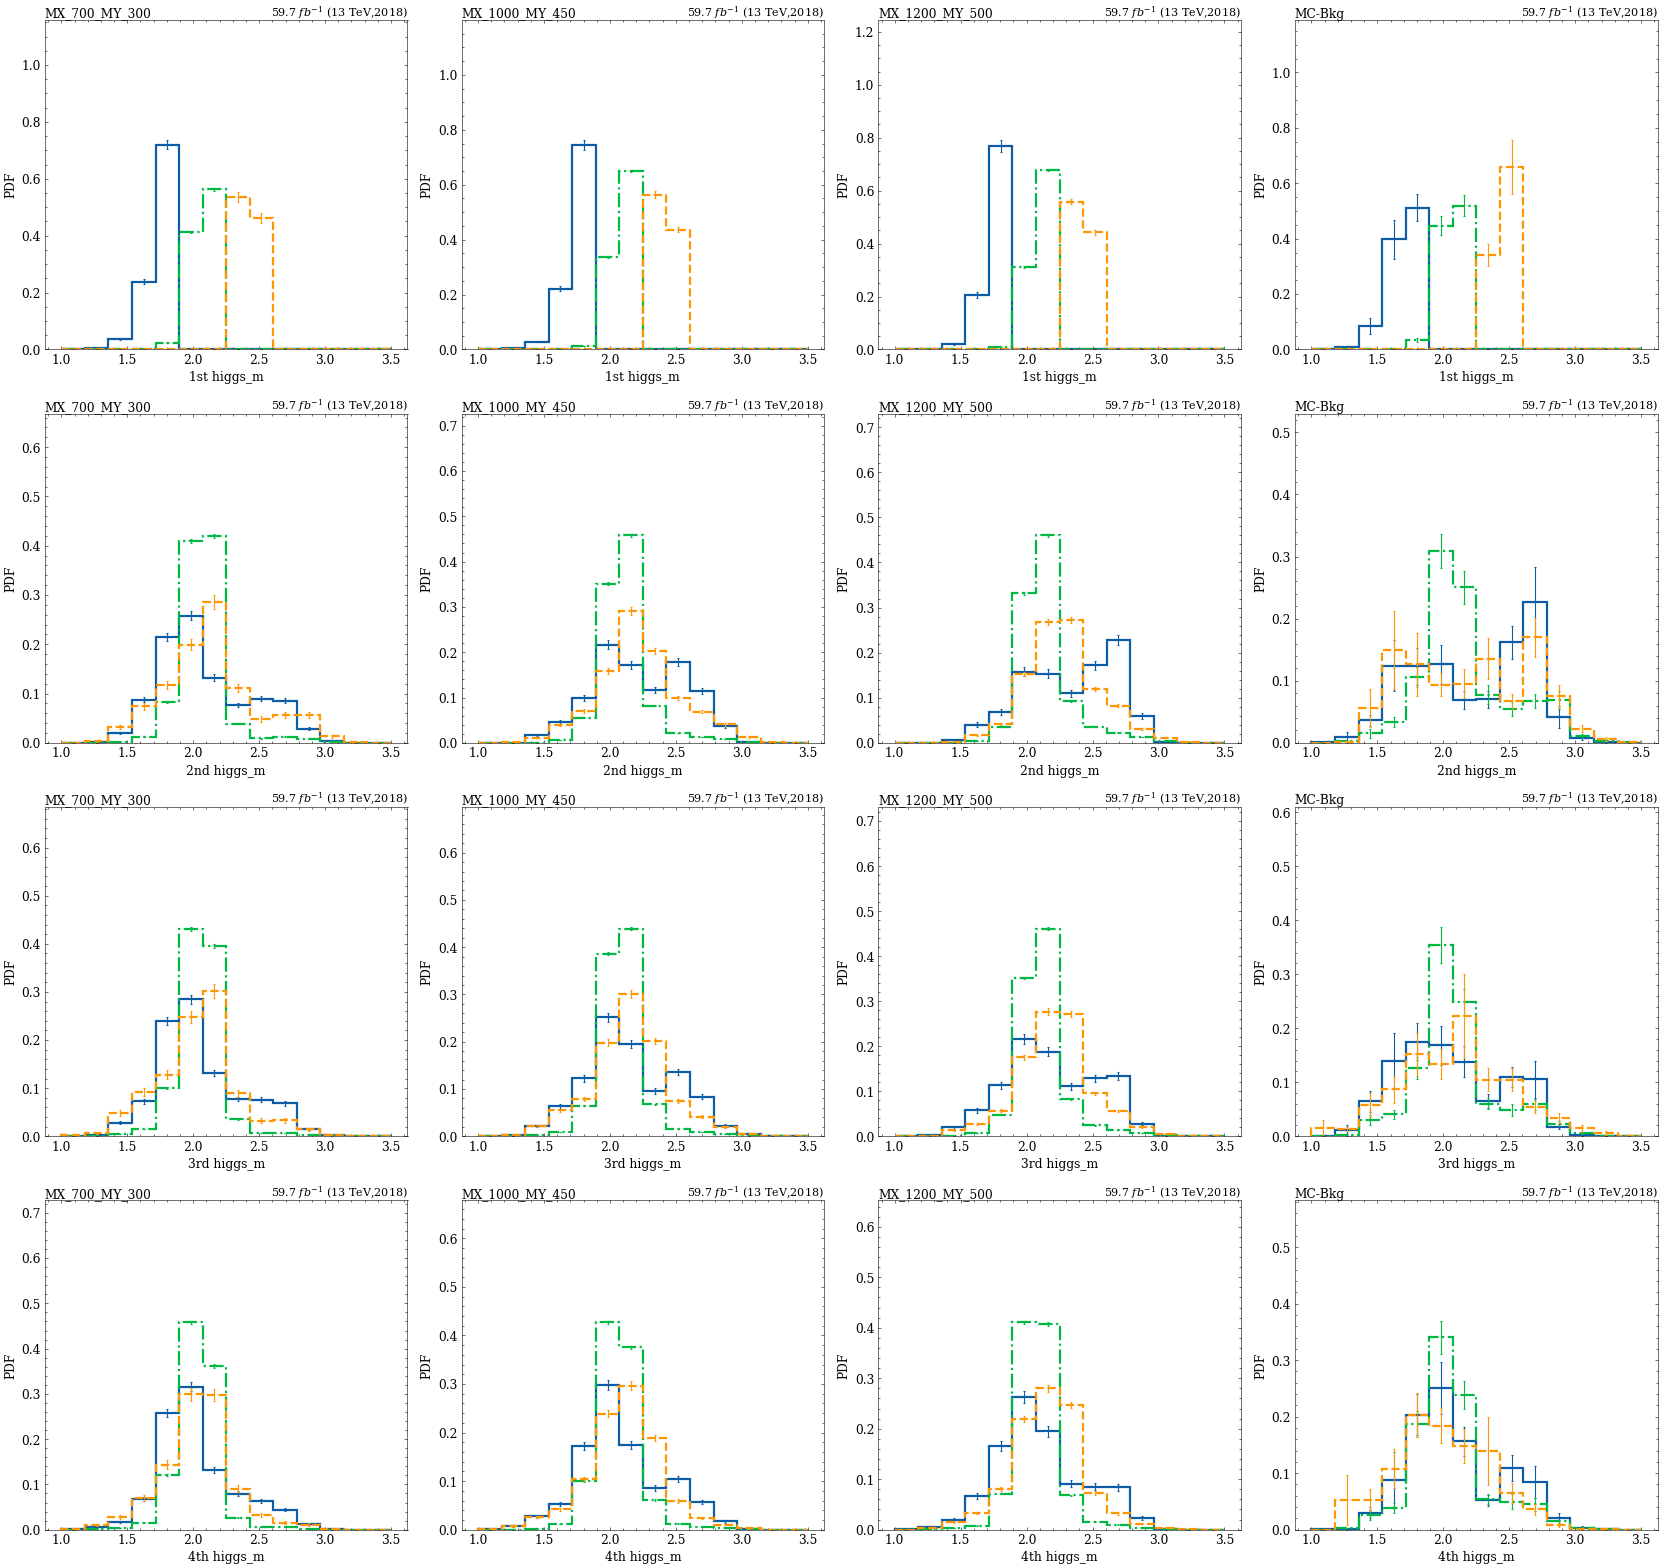

In [26]:
j = 0
study.compare_masks(
    signal,bkg,
    h_color=None,
    masks=[lambda t : np.abs(t.higgs_m[:,j] - (center[j]-100)) < 50, lambda t : np.abs(t.higgs_m[:,j] - (center[j])) < 50,lambda t : np.abs(t.higgs_m[:,j] - (center[j]+150)) < 50],
    efficiency=True,
    transforms=np.log10,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(1,3.5, 15)]*4,
    dim=-1
)

100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


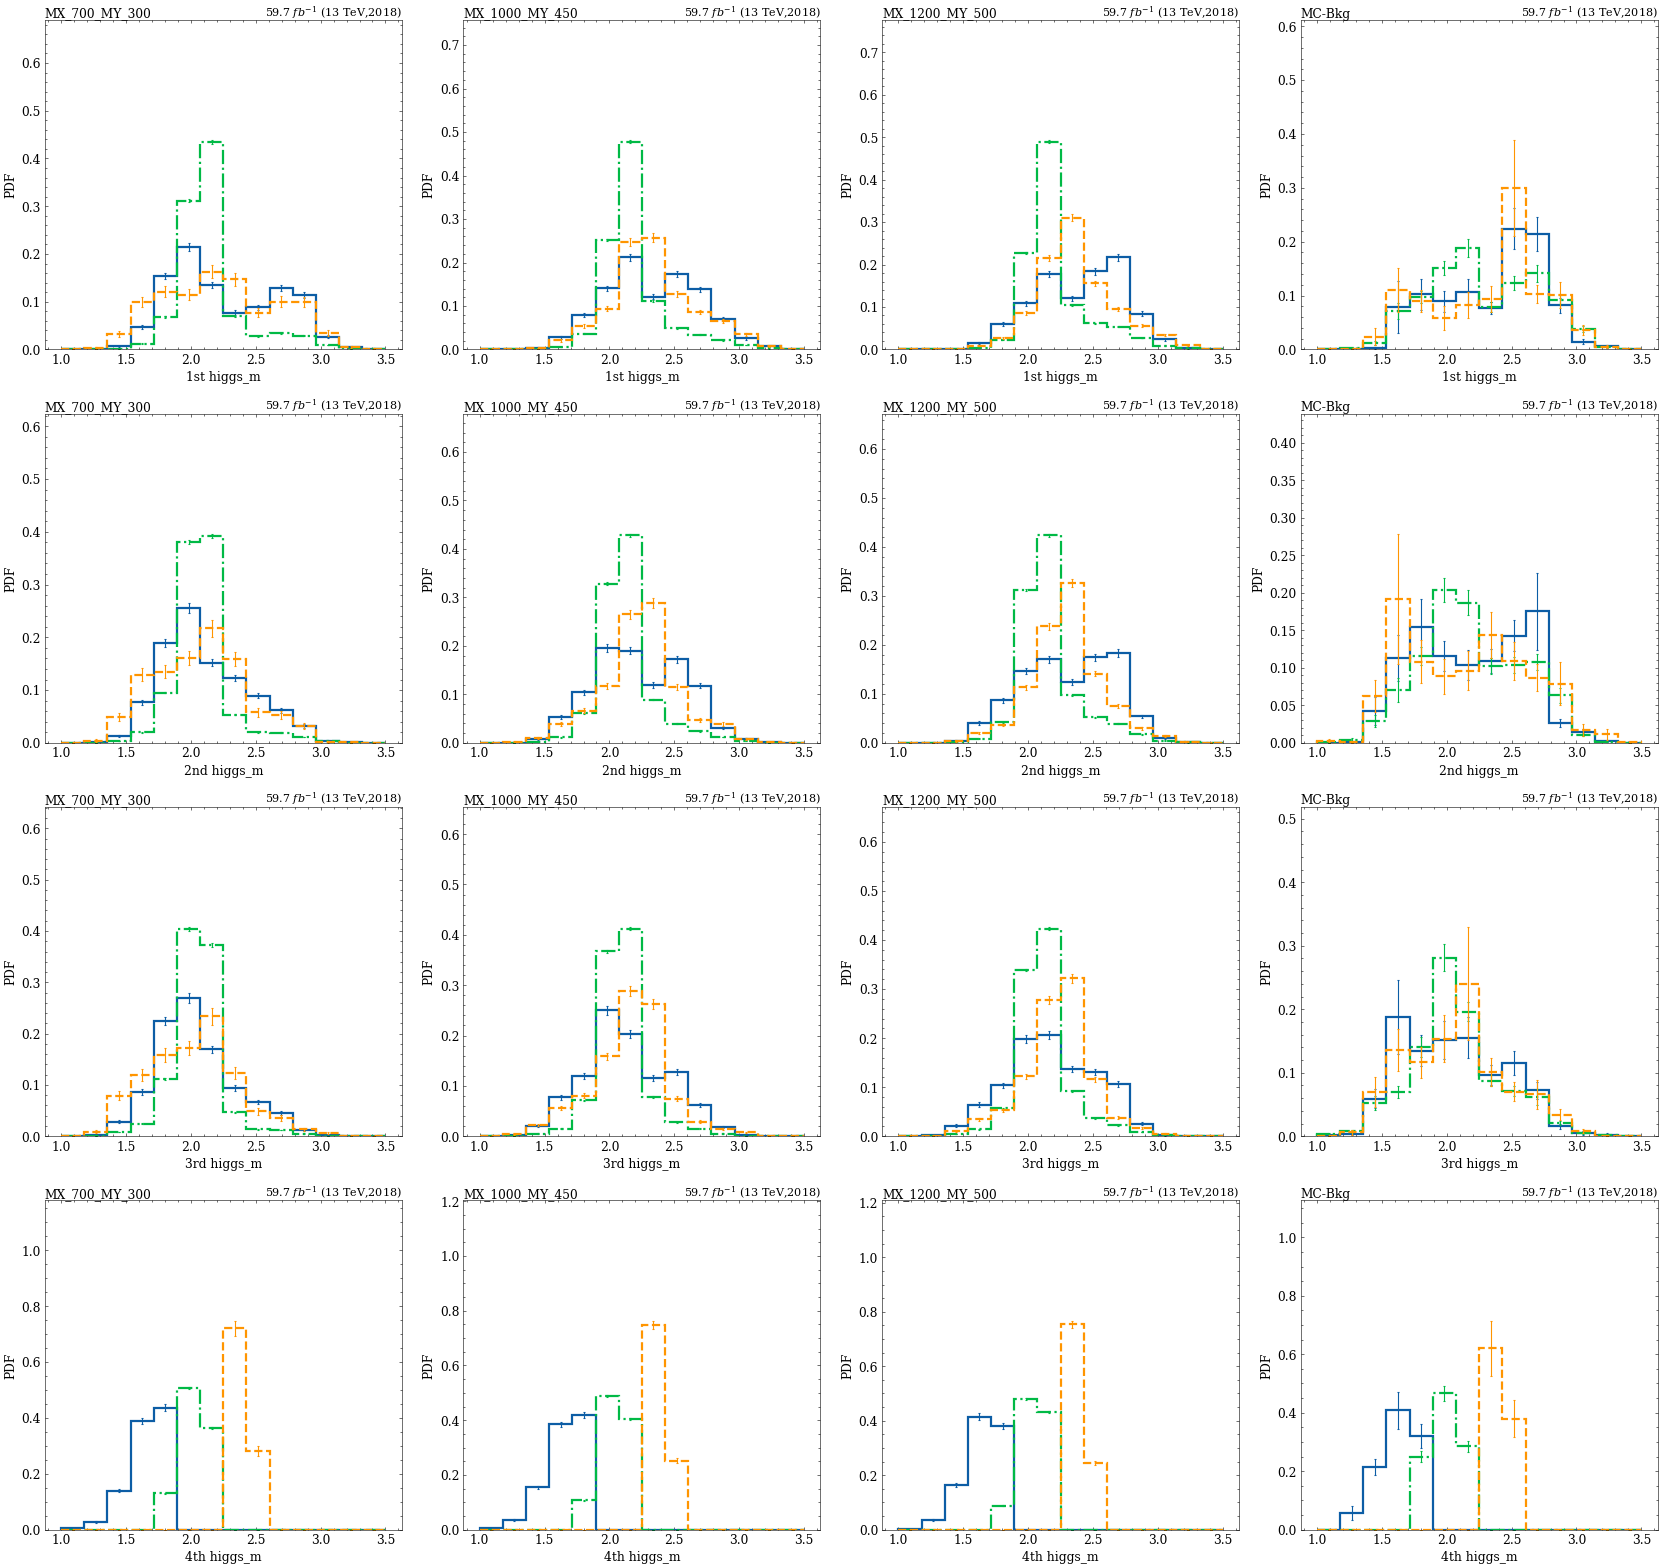

In [27]:
j = 3
study.compare_masks(
    signal,bkg,
    h_color=None,
    masks=[lambda t : np.abs(t.higgs_m[:,j] - (center[j]-100)) < 50, lambda t : np.abs(t.higgs_m[:,j] - (center[j])) < 50,lambda t : np.abs(t.higgs_m[:,j] - (center[j]+150)) < 50],
    efficiency=True,
    transforms=np.log10,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(1,3.5, 15)]*4,
    dim=-1
)

In [14]:
ar_bdt = ABCD(
    eightb.bdt_features,
    a=Filter(lambda t : (t.n_loose_btag >  5) & (t.higgs_dm < 10**2.25)),
    b=Filter(lambda t : (t.n_loose_btag == 5) & (t.higgs_dm < 10**2.25)),
    c=Filter(lambda t : (t.n_loose_btag >  5) & (t.higgs_dm > 10**2.25)),
    d=Filter(lambda t : (t.n_loose_btag == 5) & (t.higgs_dm > 10**2.25)),
)

100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


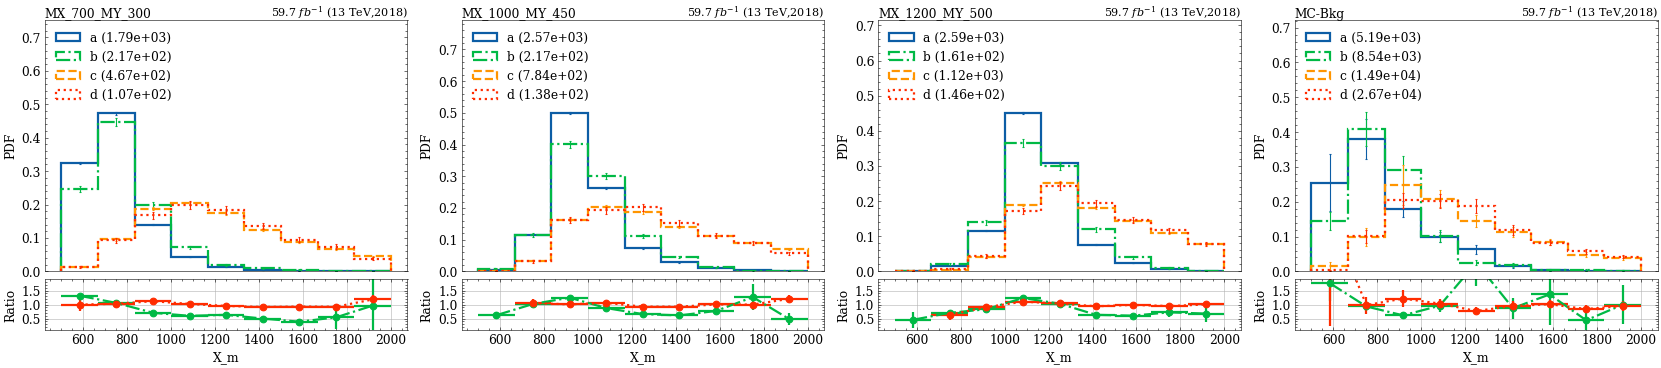

In [15]:
study.compare_masks( 
    signal,bkg,
    h_color=None,
    efficiency=True,
    masks=[getattr(ar_bdt, r) for r in ('a','b','c','d')],
    label=['a','b','c','d'],
    legend=True,
    varlist=['X_m'],
    binlist=[(500,2000,10)],
    ratio=True, r_group=[(0,1),(2,3)]
)

100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


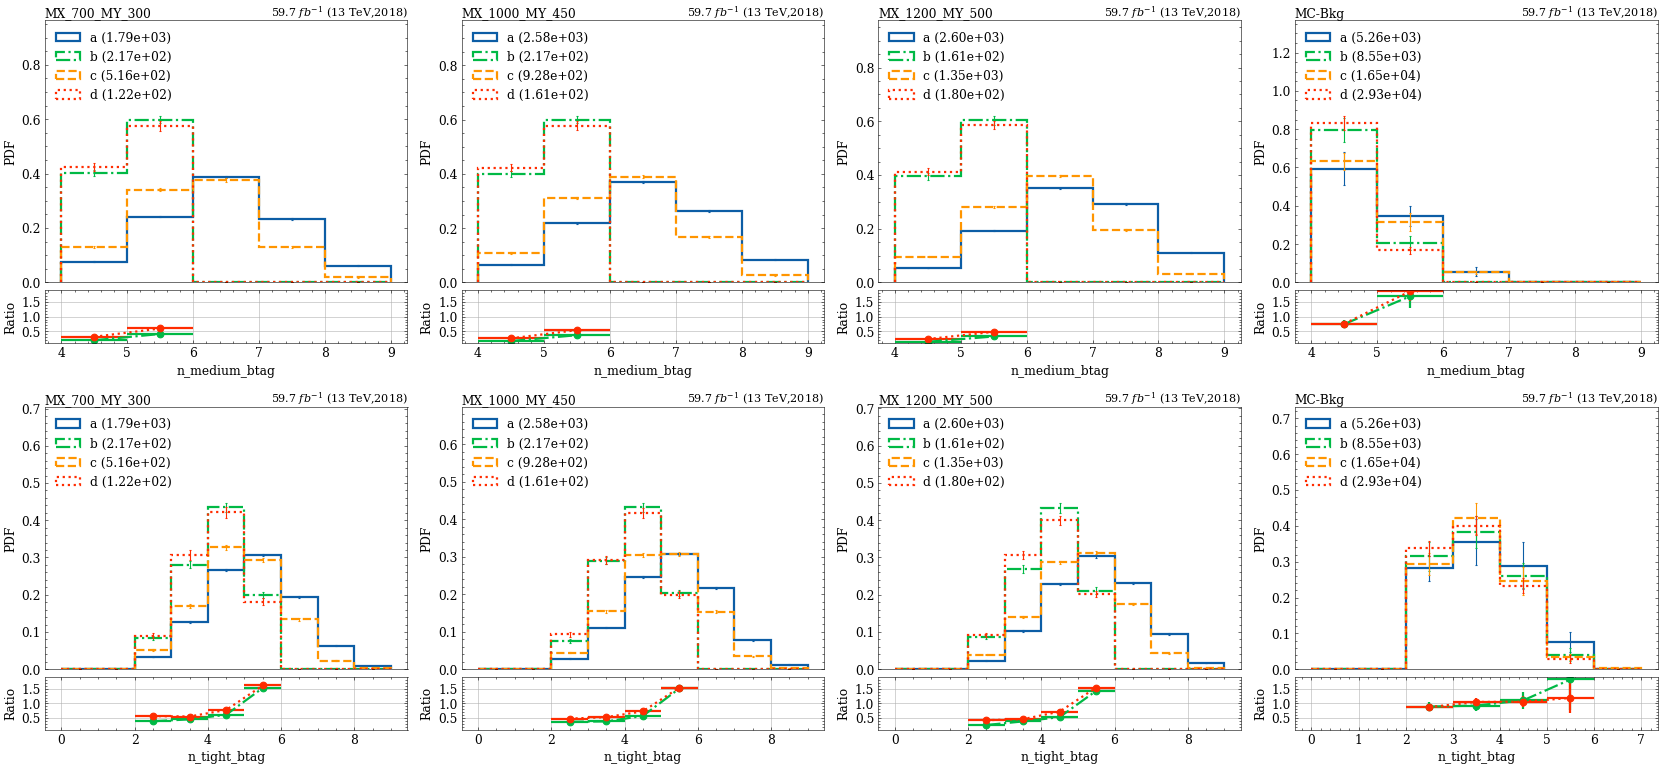

In [16]:
study.compare_masks( 
    signal,bkg,
    h_color=None,
    efficiency=True,
    masks=[getattr(ar_bdt, r) for r in ('a','b','c','d')],
    label=['a','b','c','d'],
    legend=True,
    varlist=['n_medium_btag','n_tight_btag'],
    binlist=[np.arange(4,10)],
    ratio=True, r_group=[(0,1),(2,3)]
)

100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


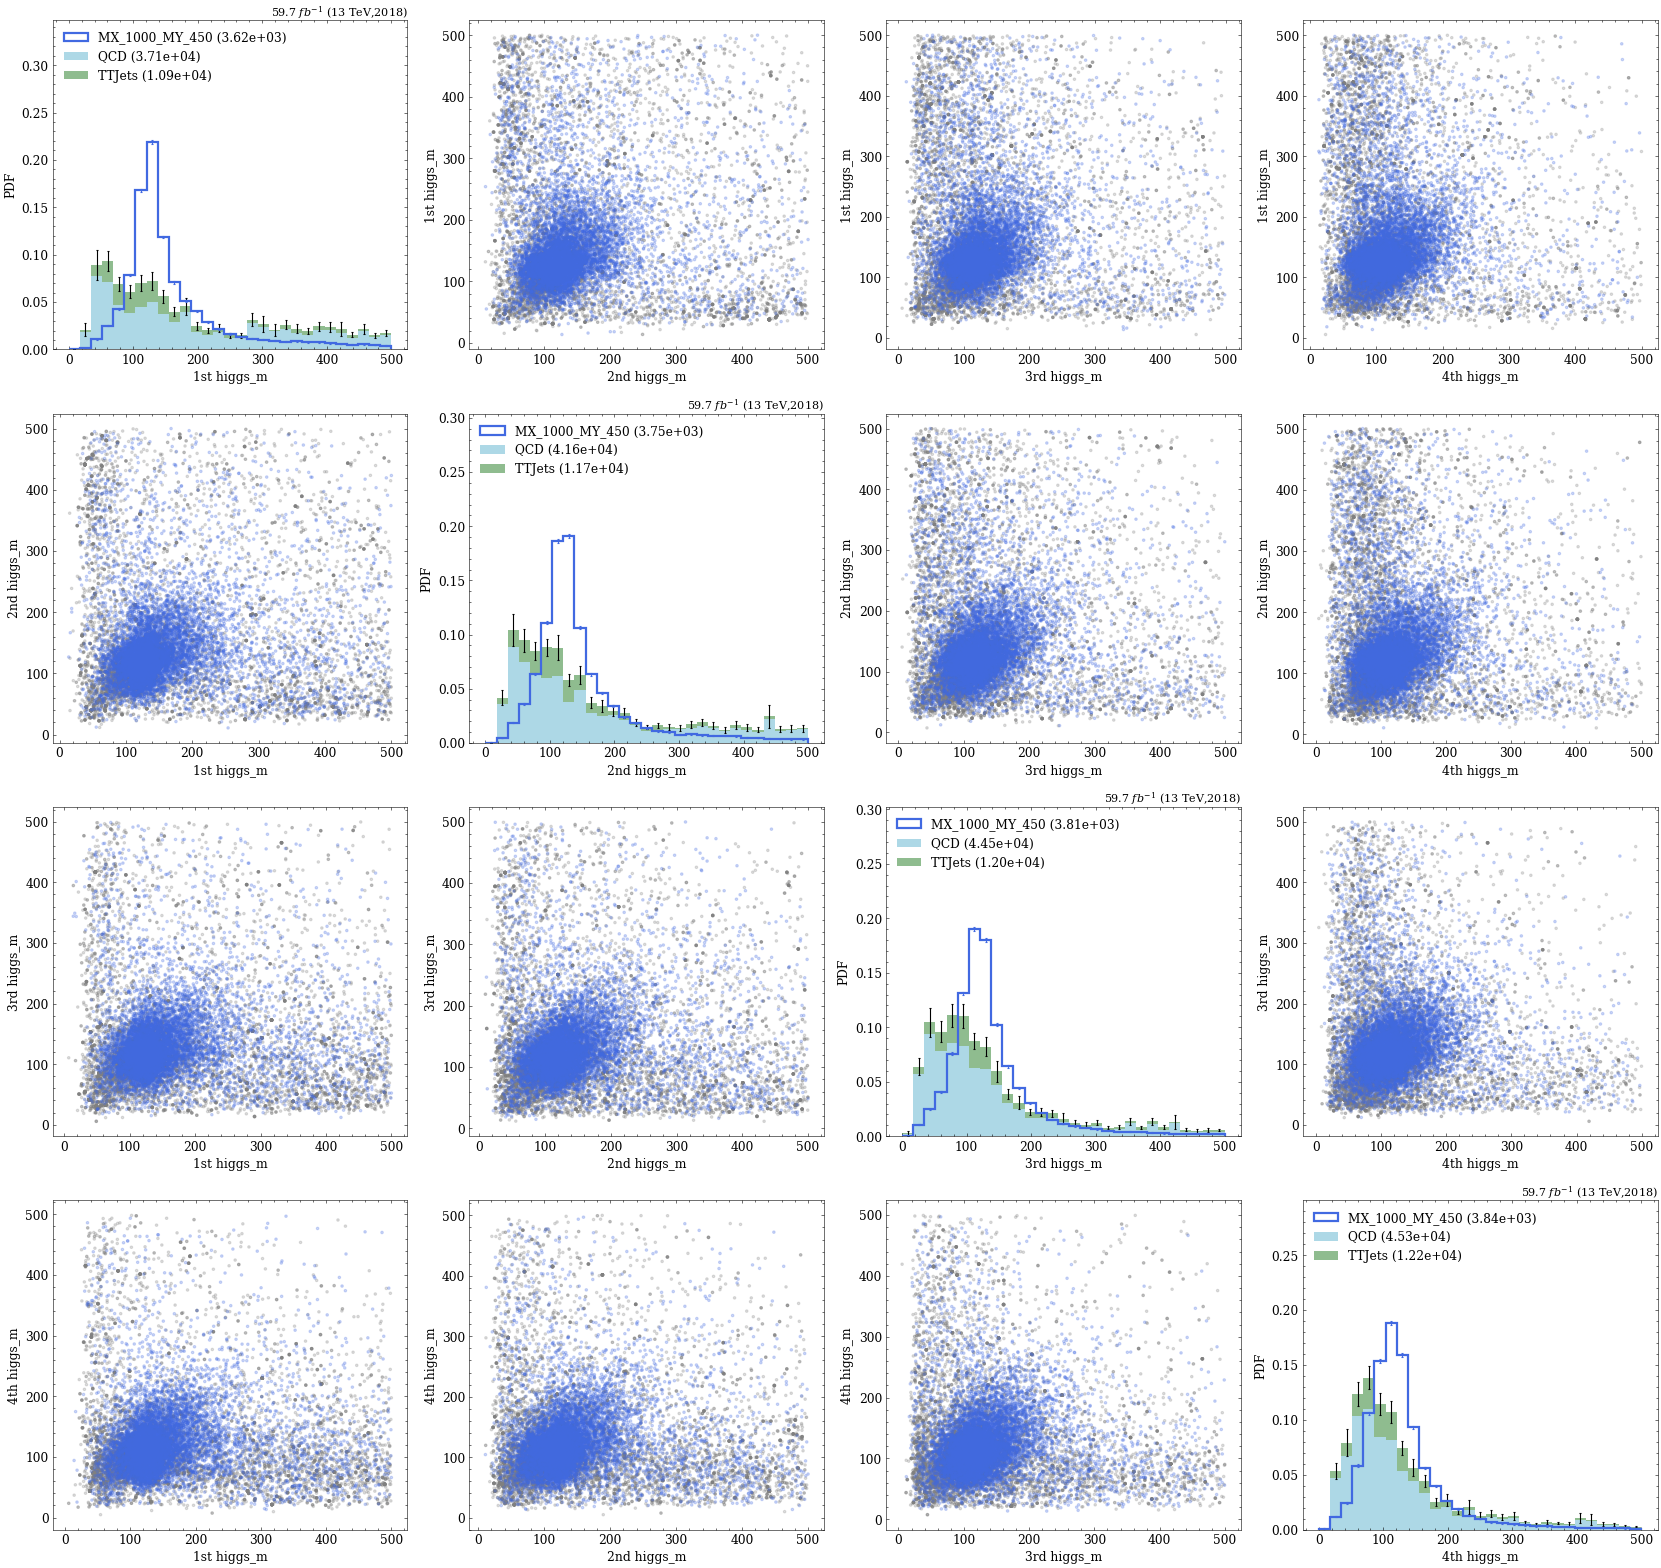

In [80]:
study.pairplot(
    signal[[1]]+bkg,
    legend=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,500,30)]*4
)

array([[124.32491862, 116.55153634, 117.97118712, 111.35773735]])